# Generate Figure 3: Dislocations

In [1]:
from skimage.io import imread
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import colorcet

from latticegen import hexlattice_gen, generate_ks
from latticegen.singularities import singularity_shift, refined_singularity
from latticegen.transformations import rotate
import pyGPA.geometric_phase_analysis as GPA
from pyGPA.imagetools import indicate_k, gauss_homogenize2
from pyGPA.property_extract import Kerelsky_plus
from pyGPA.mathtools import periodic_average


def sort_primary_ks(k_lists):
    double_ks = np.stack([np.concatenate([x, -x]) for x in k_lists])
    centerangle = periodic_average(np.arctan2(*double_ks.reshape((-1, 2)).T), period=np.pi/3)
    return [x[np.argsort(np.arctan2(*rotate(x, -centerangle).T))][3:] for x in double_ks]

## Getting experimental data and GPA

In [2]:
folder = "data"
name = "20200715_154404_0.66um_495.9_sweep-STAGE_X-STAGE_Y_highres_highE_stitch_v10_2020-11-20_1843_sobel_5_bw_200.tif"
NMPERPIXEL = 0.88

oimage = imread(os.path.join(folder, name)).squeeze()[2400:3400, 2250:3400].astype(np.float64)

In [3]:
mask = np.zeros_like(oimage, dtype=bool)
sigma = 18
dr = 2*sigma
mask[dr:-dr, dr:-dr] = 1.

In [4]:
image = gauss_homogenize2(oimage, mask, 15)
pks_exp, _ = GPA.extract_primary_ks(image[dr+100:-dr, dr+25:-dr-75], pix_norm_range=(4, 50), sigma=1.5)

closest triangle: [[ 0.00603865  0.04703476]
 [ 0.03864734  0.03476483]
 [ 0.03381643  0.03067485]
 [ 0.03381643 -0.01329243]]


In [5]:
u_exp, gs_exp = GPA.extract_displacement_field(image, pks_exp, sigma=sigma, kwscale=5, ksteps=3, return_gs=True)

In [6]:

zslices = slice(350, 750), slice(350, 750)
exx, eyy = np.mgrid[:oimage.shape[0], :oimage.shape[1]]

## Rendering dislocation in moire lattice

In [7]:
S = 1024  # Size of visualization in pixels.
r_k = 0.1
a_0 = 0.246
xi0 = 0
alphai = 3
sshift = singularity_shift(r_k, xi0, S, alpha=2*np.pi*alphai/6)  # + 0.3*np.array((2/3/r_k,0))[:,None,None]
iterated1 = 0.7 * hexlattice_gen(r_k, xi0, 3, S, shift=sshift, chunks=400).compute()
iterated1 -= iterated1.min()
theta = 4.5
shiftx = -1.5
shifty = -2
iterated2 = hexlattice_gen(r_k, xi0+theta, 3, S, shift=np.array((shiftx, shifty)), chunks=400).compute()
iterated2 -= iterated2.min()
moire = np.sqrt((iterated1)**2 + (iterated2)**2)

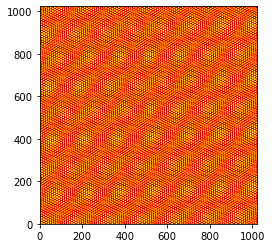

In [8]:
plt.figure()
im = plt.imshow(moire.T, cmap='cet_fire_r',
                vmax=np.quantile(moire, 0.9),
                vmin=np.quantile(moire, 0.1),
                origin='lower',
                )

closest triangle: [[-0.          0.0078125 ]
 [ 0.01367188  0.        ]
 [ 0.00683594  0.00390625]
 [ 0.00683594 -0.00390625]]


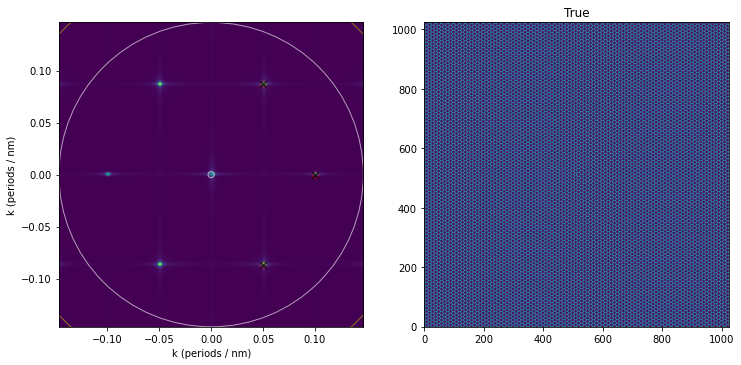

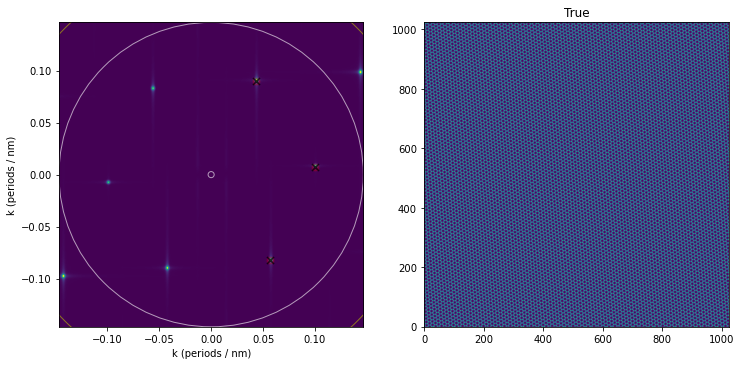

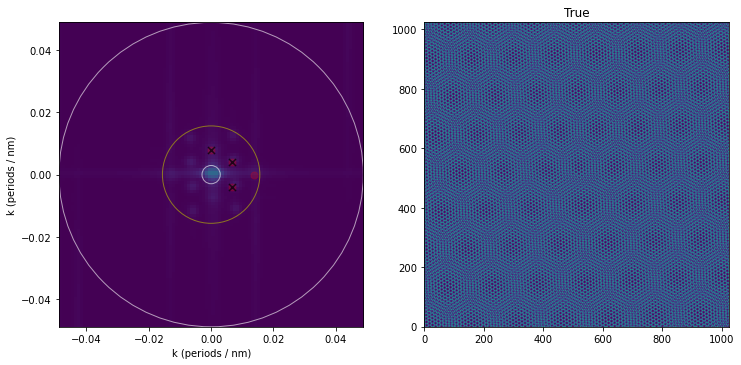

In [9]:
oks1 = generate_ks(r_k, xi0)[:3]
oks2 = generate_ks(r_k, xi0+theta)[:3]

pks1, _ = GPA.extract_primary_ks(iterated1, pix_norm_range=(3, 150), plot=True)
pks2, _ = GPA.extract_primary_ks(iterated2, pix_norm_range=(3, 150), plot=True)
pks, _ = GPA.extract_primary_ks(moire, pix_norm_range=(3, 50), plot=True, threshold=0.1, sigma=1)

pks1, pks2, pks_moire, pks_derived = sort_primary_ks([oks1, oks2, pks, pks1-pks2])
pks1, pks2, pks_moire, pks_derived = sort_primary_ks([pks1, pks2, pks, pks1-pks2])

In [10]:
u_disl, gs_disl = GPA.extract_displacement_field(iterated1, pks1, sigma=10, kwscale=4, return_gs=True)

/home/tobias/anaconda3/envs/moire-figures/lib/python3.8/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


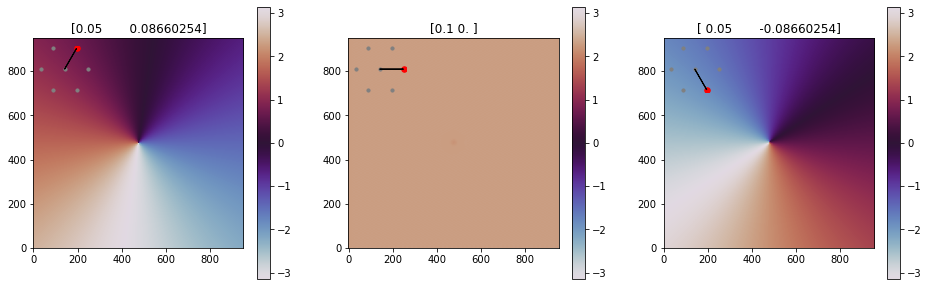

In [11]:
phases_disl = np.stack([np.angle(g['lockin']) for g in gs_disl])
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=[16, 5])
for i in range(len(gs_disl)):
    im = axs[i].imshow(phases_disl[i][dr:-dr, dr:-dr].T, cmap='twilight',
                       interpolation='none', vmax=np.pi, vmin=-np.pi, origin='lower')
    plt.colorbar(im, ax=axs[i])
    axs[i].set_title((pks1)[i])
    indicate_k((pks1), i, ax=axs[i], origin='lower')

In [12]:
msigma = 60
mdr = 2*msigma
u_moire, gs_moire = GPA.extract_displacement_field(moire, pks_derived, sigma=msigma, kwscale=4, return_gs=True)
moirephases = np.stack([np.angle(g['lockin']) for g in gs_moire])

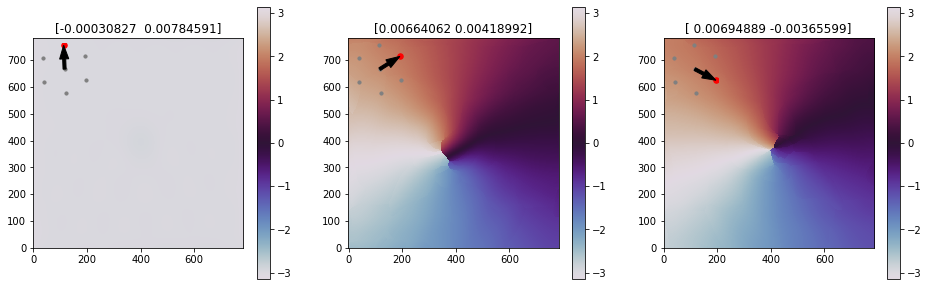

In [13]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=[16, 5])
for i in range(len(gs_moire)):
    im = axs[i].imshow(moirephases[i][mdr:-mdr, mdr:-mdr].T, cmap='twilight',
                       interpolation='none', vmax=np.pi, vmin=-np.pi, origin='lower')
    plt.colorbar(im, ax=axs[i])
    axs[i].set_title((pks_derived)[i])
    indicate_k((pks_derived), i, ax=axs[i], origin='lower')

In [14]:
z = 16
r = slice((z-1) * S // (2*z), (z+1) * S // (2*z))
w_in_nm = S*r_k*a_0//2

In [15]:
improved = refined_singularity(r_k/z*2, S=S)
improved_rot = hexlattice_gen(r_k/z*2, xi0+theta, 3, size=S, shift=np.array((shiftx, shifty))*z/2).compute()
rnew = slice(S//4, -S//4)

## Generate Figure

Arrows and inset indications as they appear in the paper were added afterwards using Illustrator

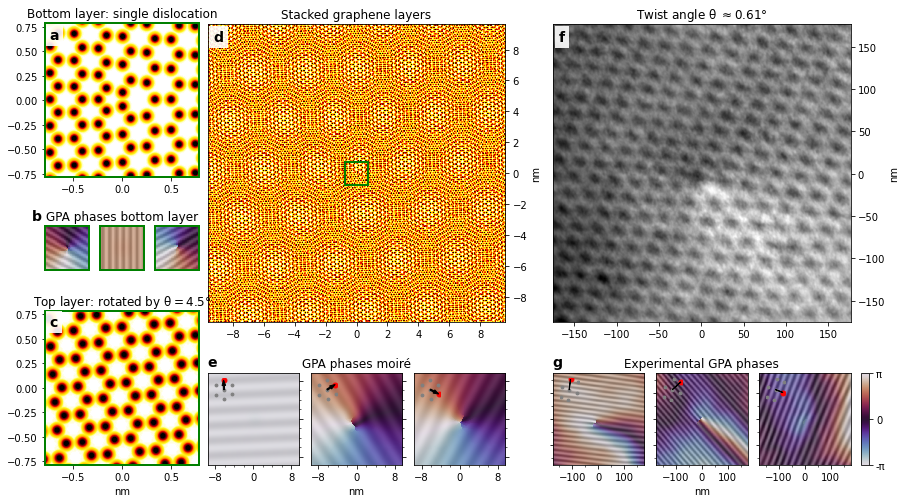

In [18]:
fig = plt.figure(figsize=[12.5, 7], constrained_layout=True)
gs0 = fig.add_gridspec(1, 2, width_ratios=[2.8, 9.8])

gsl = gs0[0].subgridspec(7, 3)
gsr = gs0[1].subgridspec(4, 6)
fig.set_constrained_layout_pads(w_pad=4 / 72, h_pad=4 / 72, hspace=0.0, wspace=0.0/72)

axmoire = fig.add_subplot(gsr[:3, :3])
axmoire.set_title('Stacked graphene layers')
axmoirephases = [fig.add_subplot(gsr[3, i]) for i in range(3)]

ax_exp = fig.add_subplot(gsr[:3, 3:])
ax_exp_phases = [fig.add_subplot(gsr[3, 3+i]) for i in range(3)]

axdisl = fig.add_subplot(gsl[:3, :3])
axdisl.set_title('Bottom layer: single dislocation')
axdislphases = [fig.add_subplot(gsl[3, i]) for i in range(3)]

axrotated = fig.add_subplot(gsl[-3:, :3])
axrotated.set_title(f'Top layer: rotated by θ$ = $4.5°')
axrotated.set_xlabel('nm')


edge = S*r_k*a_0/2
extent = np.array([-edge, edge, -edge, edge])
im = axdisl.imshow(improved[rnew, rnew].T, cmap='cet_fire_r', extent=extent/z,
                   vmax=np.quantile(improved, 0.9552),
                   # interpolation='none',
                   origin='lower',
                   )
im = axmoire.imshow(moire[mdr:-mdr, mdr:-mdr].T, cmap='cet_fire_r', extent=extent*(S-2*mdr)/S,
                    vmax=np.quantile(moire, 0.99),
                    vmin=np.quantile(moire, 0.01),
                    interpolation='none',
                    origin='lower',
                    )
im = axrotated.imshow(improved_rot[rnew, rnew].T, cmap='cet_fire_r', extent=extent/z,
                      vmax=np.quantile(improved_rot, 0.95),
                      vmin=np.quantile(improved_rot, 0.1),
                      # interpolation='none',
                      origin='lower'
                      )
mxx, myy = np.mgrid[:moire.shape[0], :moire.shape[1]]
dxx, dyy = np.mgrid[:iterated1.shape[0], :iterated1.shape[1]]

for i in range(3):
    im = axmoirephases[i].imshow(moirephases[i][mdr:-mdr, mdr:-mdr].T,
                                 cmap='twilight', interpolation='none',
                                 vmax=np.pi, vmin=-np.pi,
                                 extent=extent*(S-2*mdr) / S,
                                 origin='lower')
    kx, ky = pks_derived[i]
    mrecon = np.exp(np.pi*2*1j*(mxx*kx + myy*ky)) / np.exp(1j*moirephases[i])
    mrecon = mrecon.real
    axmoirephases[i].yaxis.tick_right()
    axmoirephases[i].yaxis.set_label_position("right")
    axmoirephases[i].tick_params(axis='y', which='both',
                                 labelleft=False, labelright=False)
    axmoirephases[i].imshow(mrecon[mdr:-mdr, mdr:-mdr].T, cmap='gray_r',
                            extent=extent*(S-2*mdr)/S,
                            alpha=0.1, origin='lower',
                            interpolation='none'
                            )

    iax = indicate_k((pks_derived), i, ax=axmoirephases[i], origin='lower', s=8)
    iax.margins(0.1)
    kx, ky = pks1[i]
    drecon = np.exp(np.pi*2*1j*(dxx*kx + dyy*ky)) / np.exp(1j*phases_disl[i])
    drecon = drecon.real
    axdislphases[i].tick_params(axis='y', which='both',
                                labelleft=False, labelright=False)
    imdisl = axdislphases[i].imshow(phases_disl[i][r, r].T,
                                    cmap='twilight', interpolation='none',
                                    vmax=np.pi, vmin=-np.pi,
                                    extent=extent/z,
                                    origin='lower')
    axdislphases[i].imshow(drecon[r, r].T, cmap='gray_r',
                           extent=extent/z,
                           alpha=0.2, origin='lower',
                           interpolation='none'
                           )
    axdislphases[i].axes.xaxis.set_visible(False)
    axdislphases[i].axes.yaxis.set_visible(False)


axdislphases[0].tick_params(axis='y', which='both', labelleft=True, labelright=False)


for ax in [axdisl, axrotated] + axdislphases:
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)
        ax.spines[axis].set_color("green")

axmoire.yaxis.tick_right()
axmoire.set_ylabel('nm')
axmoire.yaxis.set_label_position("right")
axmoire.tick_params(axis='y', which='both', labelleft=False, labelright=True)
rect = patches.Rectangle((-(1)/z*w_in_nm, -(1)/z*w_in_nm), 2/z*w_in_nm, 2/z*w_in_nm,
                         linewidth=2, edgecolor='g', facecolor='none')
axmoire.add_patch(rect)
axmoirephases[1].set_title('GPA phases moiré')
axdislphases[1].set_title('GPA phases bottom layer')
axmoirephases[1].set_xlabel('nm')


# Experimental data
###################
im = ax_exp.imshow(oimage[zslices].T, cmap='gray',
                   vmax=np.quantile(oimage[zslices], 0.9999),
                   vmin=np.quantile(oimage[zslices], 0.0001), origin='lower')

exp_extent = np.array(im.get_extent()) * NMPERPIXEL-175
im.set_extent(exp_extent)
axs = ax_exp_phases
for i in range(len(gs_exp)):
    phase = gs_exp[i]['lockin']
    kx, ky = pks_exp[i]
    recon = np.exp(np.pi*2*1j*(exx*kx + eyy*ky))/phase
    recon = recon.real

    im = axs[i].imshow(np.angle(phase)[zslices].T, cmap='twilight',
                       interpolation='none', extent=exp_extent, origin='lower', vmax=np.pi, vmin=-np.pi)

    indicate_k(pks_exp, i, ax=axs[i], origin='lower', s=8)

    axs[i].imshow(recon[zslices].T,
                  cmap='gray',
                  alpha=0.4,
                  interpolation='none',
                  extent=exp_extent, origin='lower')
axs[1].set_title('Experimental GPA phases')
axs[1].set_xlabel('nm')
for i in range(3):
    axs[i].tick_params(axis='y', which='both', labelleft=False, labelright=False)

ax_exp.set_ylabel('nm')
props = Kerelsky_plus(pks_exp, nmperpixel=NMPERPIXEL, sort=1)
angle = props[0]

ax_exp.set_title(f"Twist angle θ $\\approx${angle:.2f}°")
ax_exp.yaxis.tick_right()
ax_exp.yaxis.set_label_position("right")
ax_exp.tick_params(axis='y', which='both', labelleft=False, labelright=True)
ax_exp.tick_params(axis='x', which='both', labelleft=False, labeltop=False)
phasecbar = plt.colorbar(im, ax=axs[2], ticks=[-np.pi, 0, np.pi], shrink=0.78)
phasecbar.ax.set_yticklabels(['-π', '0', 'π'])

for ax in axmoirephases:
    ax.xaxis.set_major_locator(ticker.MultipleLocator(8))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(2))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(8))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))

axmoire.xaxis.set_major_locator(ticker.MultipleLocator(2))
axmoire.yaxis.set_major_locator(ticker.MultipleLocator(2))

for ax in axs:
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(50))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(50))

axdisl.text(0.03, 0.97, 'a', transform=axdisl.transAxes,
            fontsize=14, fontweight='bold', va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.9, edgecolor='none'))

axdislphases[0].text(-0.08, 1.08, 'b', transform=axdislphases[0].transAxes,
                     fontsize=14, fontweight='bold', va='bottom', ha='right')

axrotated.text(0.03, 0.97, 'c', transform=axrotated.transAxes,
               fontsize=14, fontweight='bold', va='top', ha='left',
               bbox=dict(facecolor='white', alpha=0.9, edgecolor='none'))

axmoire.text(0.02, 0.98, 'd', transform=axmoire.transAxes,
             fontsize=14, fontweight='bold', va='top', ha='left',
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='none'))

axmoirephases[0].text(0.1, 1.05, 'e', transform=axmoirephases[0].transAxes,
                      fontsize=14, fontweight='bold', va='bottom', ha='right')

ax_exp.text(0.02, 0.98, 'f', transform=ax_exp.transAxes,
            fontsize=14, fontweight='bold', va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.9, edgecolor='none'))

axs[0].text(0.1, 1.05, 'g', transform=axs[0].transAxes,
            fontsize=14, fontweight='bold', va='bottom', ha='right')
#fig.set_constrained_layout_pads(hspace=-1, h_pad=0.5/72)
plt.savefig(os.path.join('figures', 'dislocation2.pdf'))
plt.savefig(os.path.join('figures', 'dislocation2.png'), dpi=300)